In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [2]:
target_ts = '2min.parquet'

cwd = os.getcwd()
meta_data = os.path.join(cwd, "..", "data", "raw_data", "metadata.csv")
time_series = os.path.join(cwd, "..", "data", "raw_data", target_ts)

df_energy = pd.read_parquet(time_series)
df_spec = pd.read_csv(meta_data)

gcs_path = 'gs://energy-supply-time-series-data/30min_energy_supply_data.parquet'

df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [9]:
df_energy.head()

,generation_w,timestamp,ss_id
0,11.0,2016-12-01 07:42:27+00:00,3952
1,29.0,2016-12-01 07:42:35+00:00,6125
2,2.0,2016-12-01 07:42:35+00:00,6867
3,4.0,2016-12-01 07:42:36+00:00,3513
4,5.0,2016-12-01 07:42:36+00:00,5660


In [3]:
sample_match = df_spec[df_spec.ss_id ==3952]
sample_match

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
1547,3952,51.39,1.41,E01024656,180.0,33.0,3.99,2012-02-09


In [8]:
sample

,generation_w,timestamp,ss_id
0,11.0,2016-12-01 07:42:27+00:00,3952
7,29.0,2016-12-01 07:46:25+00:00,3952
21,79.0,2016-12-01 07:52:25+00:00,3952
58,141.0,2016-12-01 07:56:25+00:00,3952
132,221.0,2016-12-01 08:02:25+00:00,3952
...,...,...,...
558132090,9.0,2021-09-30 17:11:08+00:00,3952
558132332,8.0,2021-09-30 17:12:56+00:00,3952
558132694,5.0,2021-09-30 17:14:56+00:00,3952
558133030,3.0,2021-09-30 17:16:56+00:00,3952


In [ ]:
df_gcloud = pd.read_parquet(gcs_path,)

In [4]:
df_energy.head()

,generation_w,timestamp,ss_id
0,11.0,2016-12-01 07:42:27+00:00,3952
1,29.0,2016-12-01 07:42:35+00:00,6125
2,2.0,2016-12-01 07:42:35+00:00,6867
3,4.0,2016-12-01 07:42:36+00:00,3513
4,5.0,2016-12-01 07:42:36+00:00,5660


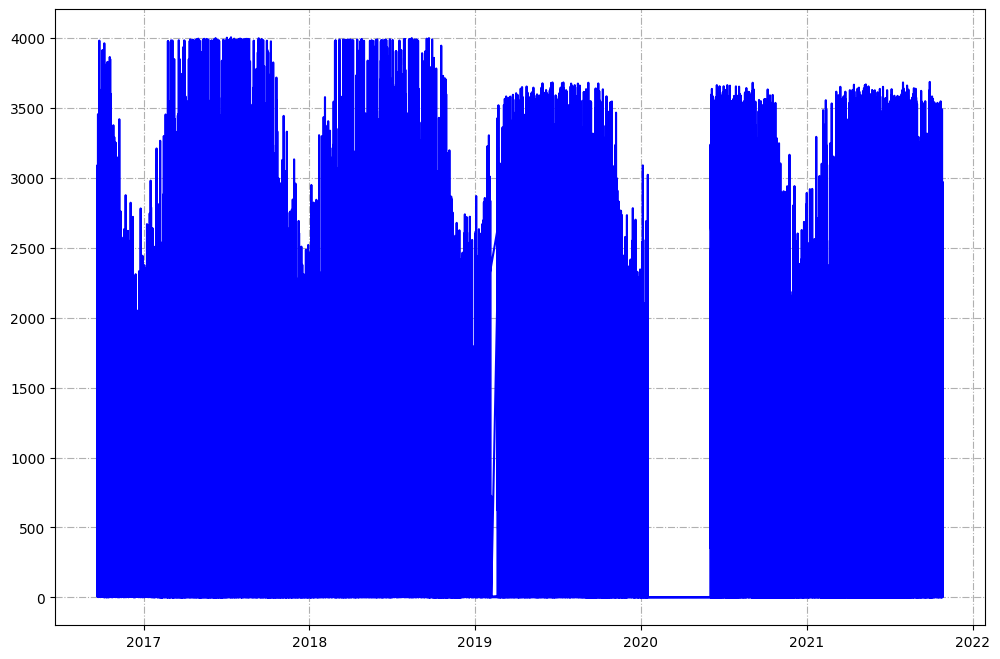

In [7]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(sample['timestamp'], sample['generation_w'], 'b')

In [7]:
sample.head(10)

NameError: name 'sample' is not defined

In [5]:
df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [54]:
import plotly.express as px
fig = px.scatter_geo(df_spec,lat=df_spec['latitude_rounded'],lon=df_spec['longitude_rounded'], scope="europe",projection="natural earth") 
fig

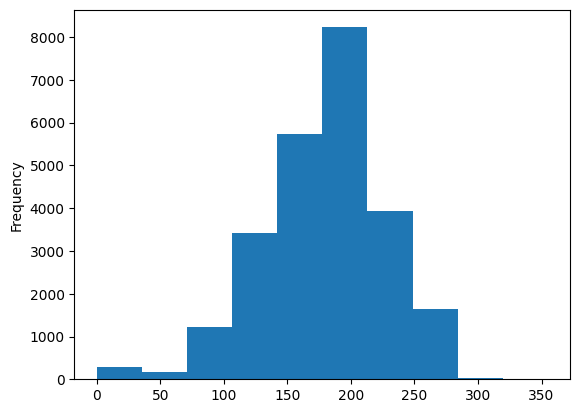

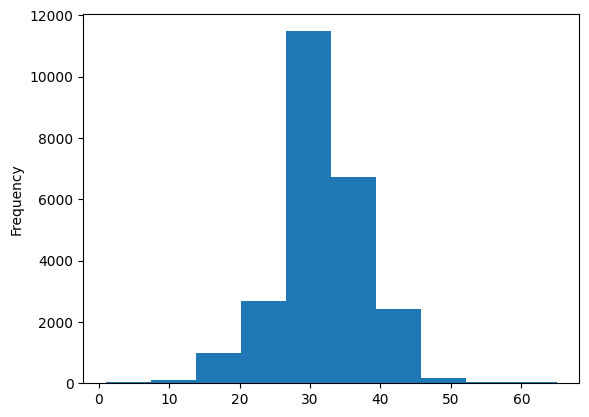

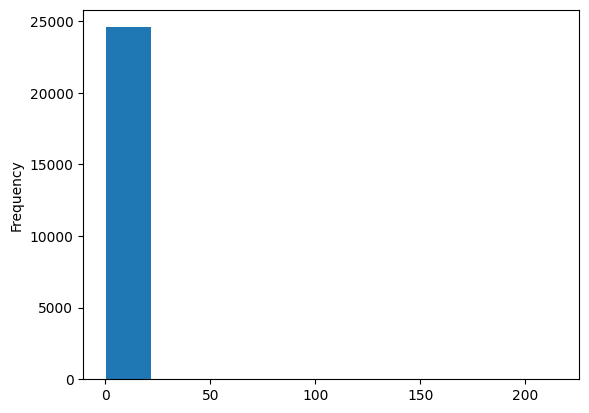

In [25]:
plt.show(df_spec.orientation.plot(kind='hist'))
plt.show(df_spec.tilt.plot(kind='hist'))

In [14]:
df_spec.orientation.unique()

array([180., 315., 225., 135., 190., 160., 215., 150., 210., 145., 217.,
       185., 170., 240., 250., 105., 200., 175., 195.,  40.,  90., 158.,
       233., 208., 159., 202., 198., 270., 174., 182., 205., 156., 197.,
       165.,  60., 130., 265., 142., 157., 219., 162., 220., 184., 209.,
       188., 230., 178., 164., 186., 110., 140., 120., 280., 124., 155.,
       177., 187., 121., 260., 272., 146., 221., 115., 100., 266., 176.,
       129., 163., 255., 193., 139., 192., 144.,  15., 181., 148., 125.,
       153., 275., 173., 191., 138., 168., 194., 183.,  50., 345.,  82.,
       166.,  45., 218., 235., 179., 213., 201., 196., 224., 152., 167.,
         7., 214., 204., 128., 147., 172., 154., 169., 161., 132., 141.,
       171., 242., 127., 104., 222., 231., 216., 258., 206., 212., 203.,
       137., 223., 149., 228., 248., 199., 123.,  48.,  31., 207., 133.,
       143., 122., 151., 114., 126., 211., 112., 108.,  32., 119.,  18.,
        35., 229., 189.,  74., 117., 136.,  94., 26

Merge the two table and start lookingn for correlations

In [55]:
df_merged = pd.merge(df_energy, df_spec, on='ss_id')

In [3]:
import xarray as xr

df_legacy = xr.open_dataset('../data/raw_data/pv.netcdf', engine="h5netcdf")

pv_power = df_legacy.sel(datetime=slice("2018-01-01", "2020-12-31"))

pv_power = pv_power.to_dataframe()

In [4]:
pv_power

,10003,10004,10005,10048,10049,10063,10064,10082,10086,10131,...,9816,9865,9866,9867,9870,9871,9902,9903,9960,9989
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:05:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:10:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:15:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:20:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 06:25:00,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-12-31 23:40:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-12-31 23:45:00,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
